# Laser Project

### Author: Alexander Pieper (815402)

This Notebook was originally developed as raw .py Code.

There, I created classes for the different usecases, which are called in a very structured Pipeline (main.py).
This has the advantage, that a new model can be added, trained and evaluated very easily and quickly.

In this notebook, I kept the content of the main code as it is, but slightly changed the structure to match jupyter notebooks. When i printed tables or plots, i refactored some of the classes, so that the nice inline plots and table vizualisation of notebooks are still possible.

Also the Plots the are created in the .py code are exported as .png file, whereas in this notebook, they are just printed directly.

### Installation:

First we have to install all the necessary packages. Note that sometimes, the Kernel has to be restarted after installing these packages.

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install interpret

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install dash

Note: you may need to restart the kernel to use updated packages.


Then we import all of the used package in the following cell.

In [8]:
# these are for analysis/preprocessing and general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import os
import random

# these are for the models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.provider import InlineProvider
from interpret import show, set_visualize_provider

# these are for the dashboard
import dash
from dash import dcc, html
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Data Analysis and Preprocessing

In this class, we define a function to get the train and test sets. We have to set the train ratio and define wether we want normalization, feature_engineering and the forward_diff (if feature_engineering is enabled).

In [9]:
class DataPreprocessing():
    def __init__(self):
        self.data_loc = os.path.join('..', 'data', 'laser.mat')
        self.data = scipy.io.loadmat(self.data_loc)
        self.X = self.data['X']
        self.y = self.data['Y']
        self.N_obs = self.X.shape[0]
        self.N_feat = self.X.shape[1]


    def get_train_test_sets(self, train_ratio:float, normalizing:bool, feature_engineering:bool, forward_diff = None):
        '''
        This function performs the train test split.
        There is also Code for local normalization (normalizing by each observation, and not the whole dataset)
        and for Min-Max Normalization, which is commented currently

        :param train_ratio: ratio of the train instances \in (0,1)
        :param normalizing: Boolean whether Z-score normalization should be applied
        :param feature_engineering: Boolean whether Feature Engineering should be applied
        :param forward_diff: only used if feature_engineering==True, then it defines the difference
        :return: 4 matrices/vectors: Training Data, X and y, testing data X and y
        '''
        random.seed(42)
        self.scaled_X = self.X.copy()

        if normalizing:
            # local normalizing (for every observation) (results in worse precision, sometimes better recall):
            # for i in range(self.X.shape[0]):
            #     self.scaled_X[i] = (self.X[i] - self.X.mean(axis = 1)[i]) / self.X.std(axis = 1)[i]
            #     self.scaled_X[i] = (self.X[i] - self.X.min(axis = 1)[i]) / (self.X.max(axis = 1)[i] - self.X.min(axis = 1)[i]) * (1 - 0) + 0

            # global normalizing:
            # Min-Max Normalization:
            # self.scaled_X = (self.X - self.X.min().min()) / (self.X.max().max() - self.X.min().min()) * (1 - 0) + 0
            # Z-Score Normalization:
            self.scaled_X = (self.X - self.X.mean().mean()) / self.X.std().mean()


        if feature_engineering:
            self.engineered_scaled_X = np.empty(shape = (self.scaled_X.shape[0], (self.scaled_X.shape[1] + 2)))
            for i in range(self.X.shape[0]):
                self.engineered_scaled_X[i] = np.concatenate((self.scaled_X[i], [np.max(self.X[i][0:len(self.X[i]) - forward_diff] - self.X[i][forward_diff:]), np.std(self.X[i])]), axis = 0)
            # this adds all diffs, not only the max of the diffs
            # self.engineered_scaled_X = np.empty(shape = (self.scaled_X.shape[0], (self.scaled_X.shape[1] * 2) - forward_diff))
            # for i in range(self.X.shape[0]):
            #     self.engineered_scaled_X[i] = np.concatenate((self.scaled_X[i], self.scaled_X[i][0:len(self.scaled_X[i]) - forward_diff] - self.scaled_X[i][forward_diff:]), axis=0)
            self.scaled_X = self.engineered_scaled_X.copy()

        indexes = sorted(random.sample(range(1, self.N_obs), int(self.N_obs * train_ratio)))
        indexes_test = sorted([i for i in range(1, self.N_obs) if i not in indexes])
        self.X_train = self.scaled_X[indexes]
        self.X_test = self.scaled_X[indexes_test]
        self.y_train = self.y[indexes]
        self.y_test = self.y[indexes_test]

        return self.X_train, self.X_test, self.y_train, self.y_test


First we want to have a look at the structure of the input data, by looking at the first three instances. After that we plot them, to get a more playful feeling of how the data looks, while also starting to determine differences between the broken and functional lasers.

In [10]:
preprocessing = DataPreprocessing()
pd.DataFrame(preprocessing.X).head(3)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,29.8509,25.7777,28.8859,30.3456,25.2192,26.2419,25.7909,26.3381,24.0290,24.1634,...,12.94550,6.65538,15.15470,10.56370,10.28170,9.57184,9.148800,9.65777,5.58567,9.82632
1,26.2727,31.2289,29.7408,34.2078,33.3289,33.6097,31.0716,22.5296,28.5874,21.1298,...,2.52577,4.63160,9.33515,6.77215,3.01827,3.67469,0.454739,5.36246,6.94501,7.90108
2,34.1790,27.0398,29.3324,31.8299,25.8882,28.2443,33.8510,26.0531,31.6576,34.3626,...,15.99610,19.49380,12.01140,11.97610,17.59420,19.59110,13.329700,14.49560,16.86710,18.78880


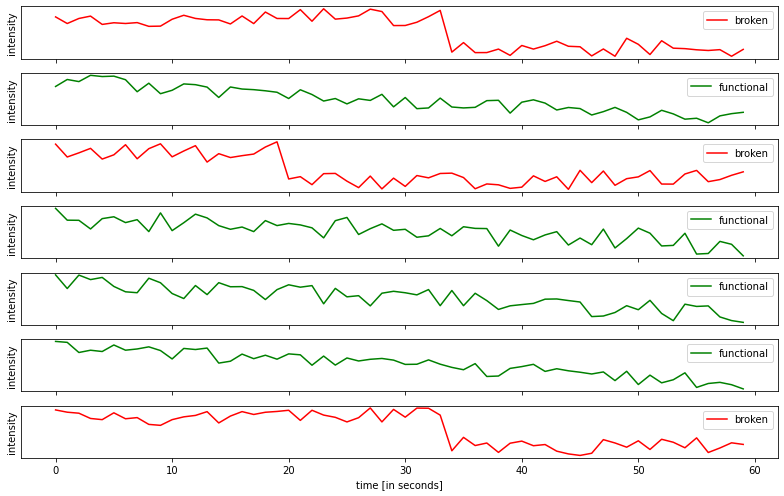

In [11]:
n_obs = 7
fig, ax = plt.subplots(n_obs,1, sharex=True,figsize = (11,7))
for i in range(n_obs):
    if preprocessing.y[i] == 1:
        ax[i].plot(preprocessing.X[i], color = 'green', alpha = 1, label = 'functional')
    else:
        ax[i].plot(preprocessing.X[i], color='red', alpha = 1, label = 'broken')
    ax[i].legend()
    ax[i].set_ylabel('intensity')
    ax[i].set_yticklabels([])
    ax[i].set_yticks([])
ax[n_obs-1].set_xlabel('time [in seconds]')
fig.tight_layout()
plt.show()



Looking at these few instances we can immideately identify differences between the two classes (broken/functional).
The broken lasers have a very sudden and steep decline of intensity at some point in time, whereas the functional ones have a more monotonically decreasing intensisty over the whole 60 seconds.

This leaves me thinking, that we are looking at an problem that is not too hard to solve. The Models we are going to build should therefore be quite precise, is this pattern we saw in these 7 instances holds ture throughout all instances.

In [12]:
print(f'We have {pd.DataFrame(preprocessing.X).isna().sum().sum()} missing values in our dataset.')
print(f'we have {preprocessing.N_obs} observations with {preprocessing.N_feat} features for each entry.')

We have 0 missing values in our dataset.
we have 200 observations with 60 features for each entry.


Now we can have a look at the summary statistics, to see wether we have outliers

In [13]:
df = pd.DataFrame(preprocessing.X)
df['std'] = df.std(axis = 1)
df['y'] = preprocessing.y.ravel()
positives = df[df['y'] == 1]
negatives = df[df['y'] == -1]
# Here we can look at the summary statistics of the positive and negative-labelled data each
positives.describe()


,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,std,y
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,30.521504,29.432372,29.580421,28.561099,28.746369,28.238569,28.150338,26.599384,26.464262,26.590511,...,11.873711,10.930618,11.672239,10.910035,10.591478,10.179617,9.511191,9.273226,7.160279,1.0
std,3.299642,3.405911,3.394614,3.399089,3.533759,3.537804,3.648150,3.765194,3.767886,3.526315,...,6.729803,6.717419,7.650093,6.997641,7.227589,7.593849,7.838372,7.545166,1.408540,0.0
min,24.172200,23.512000,23.285000,23.094500,22.499600,22.118900,21.977300,20.582200,20.622700,19.870100,...,0.078168,-1.947630,-1.399030,-2.050360,-3.789360,-1.564560,-1.592940,-5.114930,4.195647,1.0
25%,28.000300,26.861475,27.070725,25.542425,25.945425,25.558450,25.030000,23.347875,23.514375,23.582850,...,7.274873,6.690760,6.484365,6.174527,7.493935,4.207762,4.047520,5.079673,5.968403,1.0
50%,30.604650,29.201650,29.620650,28.807050,28.360750,28.328950,27.669250,25.868150,25.710750,26.701800,...,11.878050,10.586050,11.036650,10.968200,10.470900,10.614400,8.594320,8.970515,7.085805,1.0
75%,33.133575,32.458550,32.499150,31.181500,31.942675,31.051500,31.455725,29.800325,29.012600,29.189025,...,15.616175,14.448425,17.594200,14.420100,13.449100,15.138975,13.568975,12.979450,8.423272,1.0
max,35.843900,35.616100,35.297200,35.057400,34.835100,38.034300,34.069600,34.268500,37.728400,34.815700,...,49.381600,49.867900,53.030200,52.204400,54.627800,51.193000,60.271500,51.246100,9.792146,1.0


In [14]:
negatives.describe()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,std,y
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,30.025436,30.292516,30.229449,30.024909,30.087749,30.249403,29.973493,30.487096,29.792433,30.709093,...,16.937552,16.498096,16.208323,16.634492,17.206020,16.682633,16.476413,17.634142,7.454289,-1.0
std,3.624085,3.489448,3.166376,3.000432,3.518230,3.223351,3.504254,3.428466,3.540529,3.433960,...,5.209700,5.079068,5.618962,6.000060,5.575625,5.406454,5.465251,5.799907,1.594041,0.0
min,24.126000,24.178500,24.081500,24.469700,24.049900,24.026400,24.022800,24.103600,24.029000,24.115700,...,6.177770,7.593690,5.088700,4.959100,6.189270,6.353140,5.078780,6.820080,4.851423,-1.0
25%,26.984475,27.093075,27.529675,27.584675,26.879325,27.910975,27.142575,27.923025,27.139575,28.391875,...,12.623775,12.725075,12.374325,12.102850,13.629275,12.853725,12.740075,13.947175,5.912141,-1.0
50%,29.994650,30.817250,30.158100,30.172600,30.233200,30.787500,29.807200,30.443950,29.621600,31.493100,...,16.946800,16.395200,16.389400,16.295550,16.733300,16.437350,16.449050,17.923950,7.750646,-1.0
75%,33.408750,33.379100,32.783375,32.152350,32.642900,32.630475,33.210975,33.338125,32.643150,33.623150,...,20.589925,19.140875,18.929900,19.683350,20.241225,19.429400,19.693500,21.294825,8.677804,-1.0
max,35.899000,35.982400,35.952300,35.863800,35.998200,35.848000,36.000400,35.947500,36.023500,35.982000,...,36.325400,42.065800,44.773300,48.304900,47.137100,39.603600,37.562600,44.185000,10.587976,-1.0


Since the tabluar approach can be hard to grasp, here is a more insightful graphic

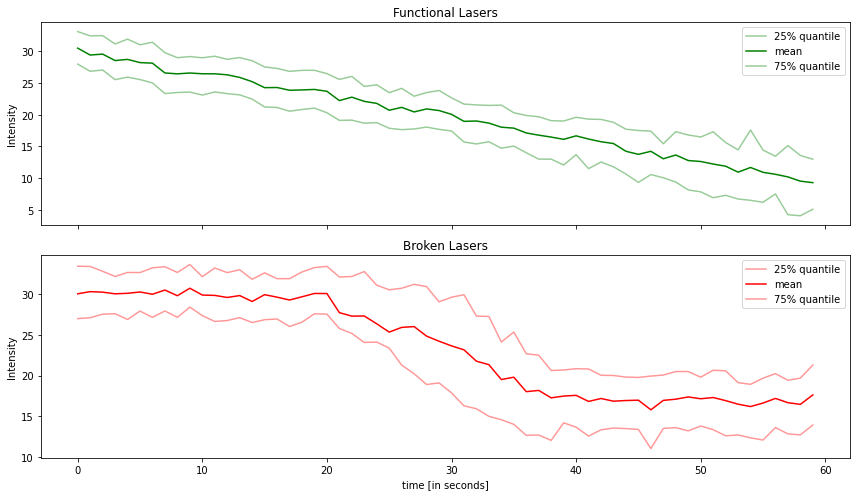

In [15]:
pos = positives.describe().drop(columns = ['std', 'y']).transpose()
neg = negatives.describe().drop(columns = ['std', 'y']).transpose()
fig, ax = plt.subplots(2,1, sharex=True,figsize = (12,7))
ax[0].plot(pos['25%'], color = 'green', alpha = 0.4, label = '25% quantile')
ax[0].plot(pos['mean'], color = 'green', alpha = 1, label = 'mean')
ax[0].plot(pos['75%'], color = 'green', alpha = 0.4, label = '75% quantile')
ax[1].plot(neg['25%'], color = 'red', alpha = 0.4, label = '25% quantile')
ax[1].plot(neg['mean'], color = 'red', alpha = 1, label = 'mean')
ax[1].plot(neg['75%'], color = 'red', alpha = 0.4, label = '75% quantile')
ax[0].legend()
ax[1].legend()
ax[0].title.set_text('Functional Lasers')
ax[1].title.set_text('Broken Lasers')
ax[0].set_ylabel('Intensity')
ax[1].set_ylabel('Intensity')
ax[1].set_xlabel('time [in seconds]')
fig.tight_layout()

Here we can again see a clear difference in the ensemble behavior of the functinal and the broken laser.

## Preprocessing and Train Test Splitting

Now we create the Train and test instances with a 50%/50% split.

the suffix `_raw` stands for no normalization and no feature engineering.


the suffix `_normalized` stands for applied normalization, but no feature engineering.


the suffix `_feat_eng_raw` stands for no normalization but applied feature engineering.


the suffix `_feat_eng_normalized` stands for applied normalization and applied feature engineering.

In [16]:
training_ratio = 0.5
X_train_raw, X_test_raw, y_train_raw, y_test_raw = preprocessing.get_train_test_sets(train_ratio=training_ratio,
                                                                                     normalizing=False,
                                                                                     feature_engineering=False)
X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = preprocessing.get_train_test_sets(train_ratio=training_ratio,
                                                                                                                 normalizing=True,
                                                                                                                 feature_engineering=False)
X_train_feat_eng_raw, X_test_feat_eng_raw, y_train_feat_eng_raw, y_test_feat_eng_raw = preprocessing.get_train_test_sets(train_ratio=training_ratio,
                                                                                                                         normalizing=False,
                                                                                                                         feature_engineering=True,
                                                                                                                         forward_diff=5)
X_train_feat_eng_normalized, X_test_feat_eng_normalized, y_train_feat_eng_normalized, y_test_feat_eng_normalized = preprocessing.get_train_test_sets(train_ratio=training_ratio,
                                                                                                                                                    normalizing=True,
                                                                                                                                                    feature_engineering=True,
                                                                                                                                                    forward_diff=5)

Here we can have a look at how the data looks after normalization.

In [17]:
pd.DataFrame(X_train_normalized).head(3)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,1.540168,0.668929,0.948709,1.253494,0.528393,0.815922,1.500141,0.548517,1.232467,1.562574,...,-0.678799,-0.251954,-1.165076,-1.169383,-0.483773,-0.240080,-1.004196,-0.861914,-0.572506,-0.337989
1,1.641849,1.553360,0.602554,0.815934,0.694691,1.307312,0.818277,0.933918,1.132690,0.785266,...,-2.400427,-1.522369,-2.242421,-1.953889,-1.304062,-2.672624,-2.304190,-2.197290,-2.418518,-2.811472
2,1.025518,1.369367,1.413983,1.348316,0.177320,0.920763,1.103499,0.639214,0.284455,0.716047,...,-0.176047,-0.219944,-0.939443,-0.301793,-0.197929,-0.475792,-0.459220,-0.399813,-1.305563,-1.162806


# Data Modelling

This cell contains multiple classes, where each class stands for one Model. Each of the models need to have the function `train_model()` and `predict()`, as they will be used to train the model and to evaluate them later on.

For each of the Model Families introduced here, we will train 4 models on the same train instances.

the model's suffix `_raw` stands for no normalization and no feature engineering in the training Inputs.


the model's suffix `_norm` stands for applied normalization, but no feature engineering in the training Inputs.


the model's suffix `_feat` stands for no normalization but applied feature engineering in the training Inputs.


the model's suffix `_norm_feat` stands for applied normalization and applied feature engineering in the training Inputs.

In [18]:

class NaiveModel():
    def __init__(self, X_train, y_train, forward_diff, name):
        self.X_train = X_train
        self.y_train = y_train
        self.forward_diff = forward_diff
        self.name = name

        self.fig_loc = os.path.join('figures')
        if not os.path.exists(self.fig_loc):
            os.makedirs(self.fig_loc)


    def train_model(self):
        # the 15 was fitted from the histogram below
        self.cutoff = 15

    def predict(self, X_test):
        predictions = np.empty(shape = (X_test.shape[0],1))
        i = 0
        for X_obs in X_test:
            if np.max(X_obs[0:len(X_obs) - self.forward_diff] - X_obs[self.forward_diff:]) > self.cutoff:
                predictions[i] = [-1]
            else:
                predictions[i] = [1]
            i += 1
        self.predictions = predictions.ravel()
        return self.predictions



class LinearModel():
    def __init__(self, X_train, y_train, name):
        self.X_train = X_train
        self.y_train = y_train
        self.name = name
        self.fig_loc = os.path.join('figures', 'logistic_regression')
        if not os.path.exists(self.fig_loc):
            os.makedirs(self.fig_loc)

    def train_model(self):
        self.model = LogisticRegression(random_state=0, max_iter = 500, verbose = 0)
        self.model.fit(self.X_train, self.y_train.ravel())


    def predict(self, X_test):
        self.predictions = self.model.predict(X_test)
        return self.predictions


    def explain_model(self):
        fig, ax = plt.subplots(1,1,figsize = (12,6))
        ax.plot(range(len(self.model.coef_[0])), self.model.coef_[0])
        ax.set_xlabel('t [in seconds]')
        ax.set_ylabel('Theta(t)')
        fig.tight_layout()
        plt.savefig(os.path.join(self.fig_loc, f'theta_values.png'))
        plt.close()





class NeuralNetSklearn():
    def __init__(self, X_train, y_train, name):
        self.X_train = X_train
        self.y_train = y_train
        self.name = name

    def train_model(self):
        self.model = MLPClassifier(hidden_layer_sizes=(24, 12, 6), activation='logistic', solver='adam', max_iter=2500, random_state = 42)
        self.model.fit(self.X_train, self.y_train.ravel())

    def predict(self, X_test):
        self.predictions = self.model.predict(X_test)
        return self.predictions




class ExplainableClassifier():
    def __init__(self, X_train, y_train, name):
        self.X_train = X_train
        self.y_train = y_train
        self.name = name
        self.fig_loc = os.path.join('figures', 'interpret_ml')
        if not os.path.exists(self.fig_loc):
            os.makedirs(self.fig_loc)

    def train_model(self):
        self.model = ExplainableBoostingClassifier()
        self.model.fit(self.X_train, self.y_train.ravel())

    def predict(self, X_test):
        self.predictions = self.model.predict(X_test)
        return self.predictions

    def explain_model(self):
        ebm_global = self.model.explain_global()
        for index, value in enumerate(self.model.feature_groups_):
            plotly_fig = ebm_global.visualize(index)
            plotly_fig.write_image(os.path.join(self.fig_loc, f'explainability_{index}.png'))




## Naive Model

The first model i created is not a Machine Learning model, but a model with a very simple classification rule:

$\hat{y_i} = \cases{1, max(\{x_{i,l} - x_{i,l+8} | l\in [1,\ldots, 52]\}) < 15\\
-1, else}$

The Threshold of 15 was fitter from the histogram below

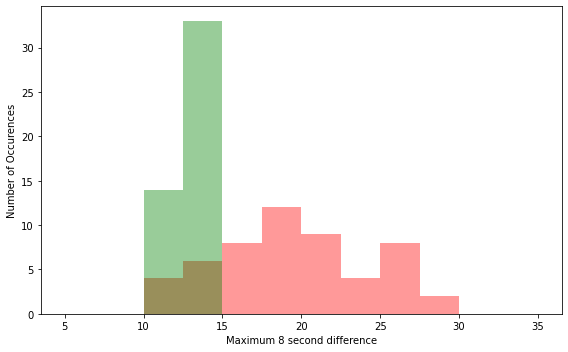

In [19]:
naive_model = NaiveModel(X_train_raw, y_train_raw, 8, 'Naive Model')
naive_model.train_model()
max_diffs_correct = []
max_diffs_faulty = []
i = 0
for y_value in naive_model.y_train:
    if y_value == 1:
        max_diffs_correct += [np.max(naive_model.X_train[i][0:len(naive_model.X_train[i]) - naive_model.forward_diff] - naive_model.X_train[i][naive_model.forward_diff:])]
    else:
        max_diffs_faulty += [np.max(naive_model.X_train[i][0:len(naive_model.X_train[i]) - naive_model.forward_diff] - naive_model.X_train[i][naive_model.forward_diff:])]
    i += 1


fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.hist(max_diffs_faulty, color = 'red', alpha = 0.4, bins = np.linspace(5,35,13))
ax.hist(max_diffs_correct, color = 'green', alpha = 0.4, bins = np.linspace(5,35,13))
ax.set_xlabel(f'Maximum {naive_model.forward_diff} second difference')
ax.set_ylabel('Number of Occurences')
fig.tight_layout()

## Linear Model

The following cell trains the 4 Logistic regression Models.

In [20]:
# Linear model
linear_model_raw = LinearModel(X_train_raw, y_train_raw, 'Linear Model (raw)')
linear_model_raw.train_model()

linear_model_norm = LinearModel(X_train_normalized, y_train_normalized, 'Linear Model (normalized)')
linear_model_norm.train_model()

linear_model_feat = LinearModel(X_train_feat_eng_raw, y_train_feat_eng_raw, 'Linear Model (feature engineered)')
linear_model_feat.train_model()

linear_model_norm_feat = LinearModel(X_train_feat_eng_normalized, y_train_feat_eng_normalized, 'Linear Model (normalized, feature engineered)')
linear_model_norm_feat.train_model()

## Explainable Model

The following cell trains the 4 Explainable Classifier models, from the interpret library.

In [21]:
# Explainable model from Microsoft
explain_ml_raw = ExplainableClassifier(X_train_raw, y_train_raw, 'Explainable Classifier (raw)')
explain_ml_raw.train_model()

explain_ml_norm = ExplainableClassifier(X_train_normalized, y_train_normalized, 'Explainable Classifier (normalized)')
explain_ml_norm.train_model()

explain_ml_feat = ExplainableClassifier(X_train_feat_eng_raw, y_train_feat_eng_raw, 'Explainable Classifier (feature engineered)')
explain_ml_feat.train_model()

explain_ml_norm_feat = ExplainableClassifier(X_train_feat_eng_normalized, y_train_feat_eng_normalized, 'Explainable Classifier (normalized, feature engineered)')
explain_ml_norm_feat.train_model()


## MLP Model

The following cell trains the 4 Multi Layer Perceptron Models using the sklearn libraries.

In [22]:
# MLP model
ann_model_sklearn_raw = NeuralNetSklearn(X_train_raw, y_train_raw, 'ANN Sklearn (raw)')
ann_model_sklearn_raw.train_model()

ann_model_sklearn_norm = NeuralNetSklearn(X_train_normalized, y_train_normalized, 'ANN Sklearn (normalized)')
ann_model_sklearn_norm.train_model()

ann_model_sklearn_feat = NeuralNetSklearn(X_train_feat_eng_raw, y_train_feat_eng_raw, 'ANN Sklearn (feature engineered)')
ann_model_sklearn_feat.train_model()

ann_model_sklearn_norm_feat = NeuralNetSklearn(X_train_feat_eng_normalized, y_train_feat_eng_normalized, 'ANN Sklearn (normalized, feature engineered)')
ann_model_sklearn_norm_feat.train_model()

# Model Evaluation

The following class uses the test instances to evaluate the different models.

Since we are looking at a binary classification task, the evaluation metrics used are gonna be precision, Recall and Accuracy. In the dashboard (which will be introduced later), we will also look at the F1 Score of the models.

In [23]:
class ModelAnalysis():
    def __init__(self, X_test, y_test, model):
        '''
        :param X_test: Input Dataset
        :param y_test: True Labels of this dataset
        :param model: Model, which maps X_test onto y_test. it has to have the predict function
        '''
        self.X_test = X_test
        self.y_test = y_test

        self.predictions = model.predict(self.X_test)
        self.model = model
        self.model_name = model.name
        model.accuracy = self.get_accuracy()
        model.precision = self.get_precision()
        model.recall = self.get_recall()

    def get_accuracy(self):
        '''
        This function calculated the Accuracy of the model on the test set
        :return: accuracy
        '''
        true_pos = ((self.y_test == 1) & (self.predictions.reshape(self.predictions.shape[0],1) == 1)).sum()
        true_neg = ((self.y_test == -1) & (self.predictions.reshape(self.predictions.shape[0],1) == -1)).sum()
        false_neg = ((self.y_test == 1) & (self.predictions.reshape(self.predictions.shape[0],1) == -1)).sum()
        false_pos = ((self.y_test == -1) & (self.predictions.reshape(self.predictions.shape[0],1) == 1)).sum()
        return (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    def get_precision(self):
        '''
        This function calculated the Accuracy of the model on the test set
        :return: precision
        '''
        true_pos = ((self.y_test == 1) & (self.predictions.reshape(self.predictions.shape[0],1) == 1)).sum()
        false_pos = ((self.y_test == -1) & (self.predictions.reshape(self.predictions.shape[0],1) == 1)).sum()
        return true_pos / (true_pos + false_pos)

    def get_recall(self):
        '''
        This function calculated the Accuracy of the model on the test set
        :return: recall
        '''
        true_pos = ((self.y_test == 1) & (self.predictions.reshape(self.predictions.shape[0],1) == 1)).sum()
        false_neg = ((self.y_test == 1) & (self.predictions.reshape(self.predictions.shape[0],1) == -1)).sum()
        return true_pos / (true_pos + false_neg)

    def make_whole_report(self):
        '''
        This function prints the three most important Evaluation metrics
        :return:
        '''
        accuracy = self.get_accuracy()
        precision = self.get_precision()
        recall = self.get_recall()
        print()
        print(f'The Precision of the model: {self.model_name} is: {np.round(precision * 100,2)}%')
        print(f'The Recall of the model: {self.model_name} is: {np.round(recall * 100,2)}%')
        print(f'The Accuracy of the model: {self.model_name} is: {np.round(accuracy * 100,2)}%')



    def make_interpretation_report(self):
        self.model.explain_model()


## Naive Model

In [24]:
ModelAnalysis(X_test_raw, y_test_raw, naive_model).make_whole_report()


The Precision of the model: Naive Model is: 89.29%
The Recall of the model: Naive Model is: 94.34%
The Accuracy of the model: Naive Model is: 90.91%


## Linear Model

In [25]:
ModelAnalysis(X_test_raw, y_test_raw, linear_model_raw).make_whole_report()
ModelAnalysis(X_test_normalized, y_test_normalized, linear_model_norm).make_whole_report()
ModelAnalysis(X_test_feat_eng_raw, y_test_feat_eng_raw, linear_model_feat).make_whole_report()
ModelAnalysis(X_test_feat_eng_normalized, y_test_feat_eng_normalized, linear_model_norm_feat).make_whole_report()


The Precision of the model: Linear Model (raw) is: 100.0%
The Recall of the model: Linear Model (raw) is: 94.34%
The Accuracy of the model: Linear Model (raw) is: 96.97%

The Precision of the model: Linear Model (normalized) is: 100.0%
The Recall of the model: Linear Model (normalized) is: 94.34%
The Accuracy of the model: Linear Model (normalized) is: 96.97%

The Precision of the model: Linear Model (feature engineered) is: 100.0%
The Recall of the model: Linear Model (feature engineered) is: 96.23%
The Accuracy of the model: Linear Model (feature engineered) is: 97.98%

The Precision of the model: Linear Model (normalized, feature engineered) is: 100.0%
The Recall of the model: Linear Model (normalized, feature engineered) is: 96.23%
The Accuracy of the model: Linear Model (normalized, feature engineered) is: 97.98%


## Explainable Model

In [26]:
ModelAnalysis(X_test_raw, y_test_raw, explain_ml_raw).make_whole_report()
ModelAnalysis(X_test_normalized, y_test_normalized, explain_ml_norm).make_whole_report()
ModelAnalysis(X_test_feat_eng_raw, y_test_feat_eng_raw, explain_ml_feat).make_whole_report()
ModelAnalysis(X_test_feat_eng_normalized, y_test_feat_eng_normalized, explain_ml_norm_feat).make_whole_report()


The Precision of the model: Explainable Classifier (raw) is: 98.0%
The Recall of the model: Explainable Classifier (raw) is: 92.45%
The Accuracy of the model: Explainable Classifier (raw) is: 94.95%

The Precision of the model: Explainable Classifier (normalized) is: 98.0%
The Recall of the model: Explainable Classifier (normalized) is: 92.45%
The Accuracy of the model: Explainable Classifier (normalized) is: 94.95%

The Precision of the model: Explainable Classifier (feature engineered) is: 98.04%
The Recall of the model: Explainable Classifier (feature engineered) is: 94.34%
The Accuracy of the model: Explainable Classifier (feature engineered) is: 95.96%

The Precision of the model: Explainable Classifier (normalized, feature engineered) is: 98.04%
The Recall of the model: Explainable Classifier (normalized, feature engineered) is: 94.34%
The Accuracy of the model: Explainable Classifier (normalized, feature engineered) is: 95.96%


## MLP Model

In [27]:
ModelAnalysis(X_test_raw, y_test_raw, ann_model_sklearn_raw).make_whole_report()
ModelAnalysis(X_test_normalized, y_test_normalized, ann_model_sklearn_norm).make_whole_report()
ModelAnalysis(X_test_feat_eng_raw, y_test_feat_eng_raw, ann_model_sklearn_feat).make_whole_report()
ModelAnalysis(X_test_feat_eng_normalized, y_test_feat_eng_normalized, ann_model_sklearn_norm_feat).make_whole_report()


The Precision of the model: ANN Sklearn (raw) is: 93.88%
The Recall of the model: ANN Sklearn (raw) is: 86.79%
The Accuracy of the model: ANN Sklearn (raw) is: 89.9%

The Precision of the model: ANN Sklearn (normalized) is: 96.08%
The Recall of the model: ANN Sklearn (normalized) is: 92.45%
The Accuracy of the model: ANN Sklearn (normalized) is: 93.94%

The Precision of the model: ANN Sklearn (feature engineered) is: 90.38%
The Recall of the model: ANN Sklearn (feature engineered) is: 88.68%
The Accuracy of the model: ANN Sklearn (feature engineered) is: 88.89%

The Precision of the model: ANN Sklearn (normalized, feature engineered) is: 95.83%
The Recall of the model: ANN Sklearn (normalized, feature engineered) is: 86.79%
The Accuracy of the model: ANN Sklearn (normalized, feature engineered) is: 90.91%


# Interpretation Report

Often, ML models are Blackboxes, whose decision making can be hard to understand. The following is an approach to evaluate these Model w.r.t. their decision making.



## Linear Model

Here we can see a plot of the values of the parameter vector $\theta$. 

#### Log odds
These parameter have some explainability to them, as a negative value $\theta_t$ says the following: 'The larger the intensity of the Laser at time $t$, the more likely it it, that it is broken'. Vice Versa does a very positive value, stand for 'the higher the intensity, the more likely, i am going to predict a positive label (functional)'

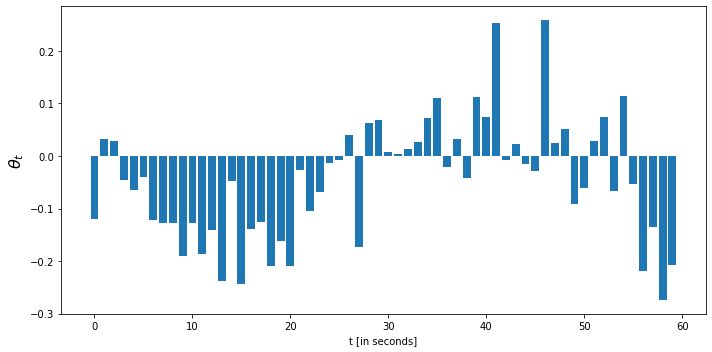

In [28]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.bar(range(len(linear_model_raw.model.coef_[0])), linear_model_raw.model.coef_[0])
ax.set_xlabel('t [in seconds]')
ax.set_ylabel(r'$\theta_t$', size = 16)
fig.tight_layout()

#### Odds:
It is also goot to look at the odds of these features. The odds of a feature are calculated by $e^{\theta_t}$.

This is interpreted as For every unit, the laser intesity at time $t$ increases, the laser is $e^{\theta_t}$ time more likely to be a functional one.

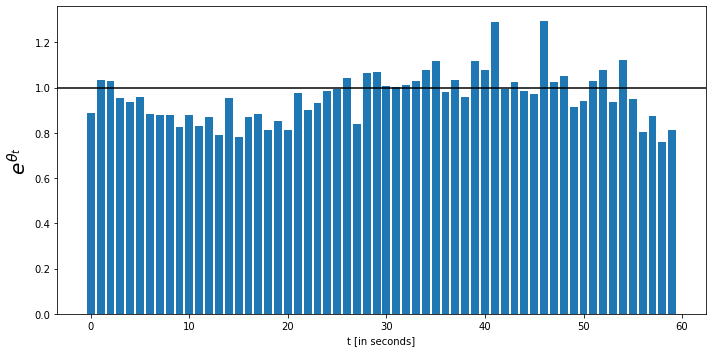

In [29]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.bar(range(len(linear_model_raw.model.coef_[0])), np.exp(linear_model_raw.model.coef_[0]))
ax.set_xlabel('t [in seconds]')
ax.set_ylabel(r'$e^{\theta_t}$', size = 20)
ax.axhline(1, color = 'black')
fig.tight_layout()

## Explainable Model

The Explainability of the explainable model goes far beyond that. After all it was developed for exactly this reason.

Below this cell, there is a little dashboard where one can choose a Feature of the Dataset, as well as combintations of features.

When you selecto one, you get a detailed analysis of this feature. This starts with a line graph, that has the feature's range on the x axis and the `Score` of the model on the y axis. You read this graph as: if the Feature `F` has a value of `x`, we give it Score `y`. the higher this score, the more likely we will classify it as positive/functional.

Below this graph, there is also a histogram, showing the distribution of this feature. This can help understanding outliers or where certain bulks of data are.

In [30]:
# When working in Jupyter notebook, i had to uncomment the following. In VS Code it only work then it is commented.
# set_visualize_provider(InlineProvider())
ebm_global = explain_ml_feat.model.explain_global()
show(ebm_global)

/Users/alexanderpieper/opt/anaconda3/lib/python3.8/site-packages/interpret/visual/udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/alexanderpieper/opt/anaconda3/lib/python3.8/site-packages/interpret/visual/udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/alexanderpieper/opt/anaconda3/lib/python3.8/site-packages/interpret/visual/udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt


<!-- http://127.0.0.1:7826/140653376073680/ -->

## MLP Model

For the Multilayer Perceptron, there is no easy or intuitive way to determine the decisionmaking.

# Evaluation Dashboard

The last thing in this Notebook, is a Dashboard that contains the possibility for an interactive comparison between the models.

Not only does it show all the metrics for the differrent models, we can also see the Test instances and when you select a model from the dropdown list, you can also see the misclassifications of this model. 
If a Laser is then plotted bold and green, this Laser is a false negative, as it was classified as broken, but is in fact functional.
Vice versa is a bold red line a broken Laser, which was classified as broken.

In [31]:
import dash
import dash_html_components as html
from dash import dcc
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd


def make_evaluation_dashboard(X_test, y_test, *models):
    '''

    :param X_test:
    :param y_test:
    :param models: all the models, that should be included in the Evaluation
    :return: a dashboard, running on localhost with port 8050
    '''
    ncols = 3

    app = dash.Dash()

    df = pd.DataFrame(X_test)
    df['y_true'] = y_test.ravel()
    df = df.reset_index()

    # initialize the first evaluation DataFrame with all models
    evaluation_df =pd.DataFrame({
            'Model Name': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': [],
        })
    for model in models:
        evaluation_df.loc[model.name, 'Model Name'] = model.name
        evaluation_df.loc[model.name, 'Precision'] = model.precision
        evaluation_df.loc[model.name, 'Recall'] = model.recall
        evaluation_df.loc[model.name, 'F1-Score'] = (2 * model.precision * model.recall) / (model.precision + model.recall)



    percentage = dash.dash_table.FormatTemplate.percentage(2)
    format = dash.dash_table.Format.Format()
    all_options = [{'label': 'All Models', 'value':
                         {'predictions': y_test.ravel(),
                          'recall': 1,
                          'precision': 1,
                          'label': 'All Models',
                          }}] + [
                        {'label': i.name, 'value': {'predictions':i.predictions,
                                                    'recall':i.recall,
                                                    'precision':i.precision,
                                                    'label':i.name,
                                                    }} for i in models
                    ]

    # This defines the layout of the Dashboard
    app.layout = html.Div(id='parent', children=[
        html.H1(id='H1', children='Laser Project Model Evaluation', style={'textAlign': 'center', 'marginTop': 40, 'marginBottom': 40}),
        dcc.Dropdown(id='dropdown',
                    options = all_options,
                    placeholder = "Select a model",
                    value = {'predictions':y_test.ravel(),
                                'recall':1,
                                'precision':1,
                                'label':'All Models',
                                }
                     ),
        dash.dash_table.DataTable(data=evaluation_df.to_dict('records'),
                                  columns=[{"name": i, "id": i, "format": (percentage if i != 'Model Name' else format), 'type': ('numeric' if i != 'Model Name' else 'string')} for i in evaluation_df.columns],
                                  sort_action="native",
                                  filter_action="native",
                                  id='eval_table'),
        dcc.Graph(id='graph'),
    ])

    # Here we update the Table, when a value from the dropdown is chosen
    @app.callback(
        dash.Output('eval_table', 'data'),
        dash.Input('dropdown', 'value'))
    def update_table(selected_model):
        if selected_model['label'] == 'All Models':
            evaluation_df = pd.DataFrame({
                'Model Name': [],
                'Precision': [],
                'Recall': [],
                'F1-Score': [],
            })
            for model in models:
                # print(model.name)
                # print(model.accuracy)
                evaluation_df.loc[model.name, 'Model Name'] = model.name
                evaluation_df.loc[model.name, 'Precision'] = model.precision
                evaluation_df.loc[model.name, 'Recall'] = model.recall
                evaluation_df.loc[model.name, 'F1-Score'] = (2 * model.precision * model.recall) / (
                            model.precision + model.recall)
        else:
            f1_score = (2 * selected_model['precision'] * selected_model['recall']) / (selected_model['precision'] + selected_model['recall'])
            evaluation_df = pd.DataFrame({
                'Model Name': [selected_model['label']],
                'Precision': [selected_model['precision']],
                'Recall': [selected_model['recall']],
                'F1-Score': [f1_score],
            })
        return evaluation_df.to_dict(orient='records')

    # Here we update the Graph, when a value from the dropdown is chosen
    @app.callback(
        dash.Output('graph', 'figure'),
        dash.Input('dropdown', 'value'))
    def update_figure(selected_model):
        if isinstance(selected_model['predictions'][0], list):
            selected_model['predictions'] = [i[0] for i in selected_model['predictions']]
        df['y_pred'] = selected_model['predictions']



        if len(y_test.ravel())%ncols != 0:
            n_rows = int(len(y_test.ravel())/ncols + 1)
        else:
            n_rows = int(len(y_test.ravel())/ncols)

        fig = make_subplots(cols=ncols, rows=n_rows)
        row_index=0
        column_index = 0
        for i in range(len(y_test.ravel())):
            if row_index >= n_rows:
                column_index += 1
                row_index = 0
            if (y_test.ravel()[i] == 1) & (selected_model['predictions'][i] == 1):
                fig.add_trace(
                    go.Scatter(x=list(range(len(df.iloc[i].drop(['index', 'y_true', 'y_pred'])))),
                               y=df.iloc[i].drop(['index', 'y_true', 'y_pred']), line=dict(color='rgba(177, 221, 140, 0.8)')), row=row_index + 1, col= column_index + 1)
            elif  (y_test.ravel()[i] == -1) & (selected_model['predictions'][i] == -1):
                fig.add_trace(
                    go.Scatter(x=list(range(len(df.iloc[i].drop(['index', 'y_true', 'y_pred'])))),
                               y=df.iloc[i].drop(['index', 'y_true', 'y_pred']), line=dict(color="rgba(255, 98, 81, 0.5)")), row=row_index + 1, col=column_index + 1)
            elif (y_test.ravel()[i] == 1) & (selected_model['predictions'][i] == -1):
                fig.add_trace(
                    go.Scatter(x=list(range(len(df.iloc[i].drop(['index', 'y_true', 'y_pred'])))),
                               y=df.iloc[i].drop(['index', 'y_true', 'y_pred']), line=dict(color="rgba(177, 221, 140, 1)", width=5)), row=row_index + 1, col=column_index + 1)
            elif (y_test.ravel()[i] == -1) & (selected_model['predictions'][i] == 1):
                fig.add_trace(
                    go.Scatter(x=list(range(len(df.iloc[i].drop(['index', 'y_true', 'y_pred'])))),
                               y=df.iloc[i].drop(['index', 'y_true', 'y_pred']), line=dict(color="rgba(255, 98, 81, 1)", width=5)), row=row_index + 1, col=column_index + 1)
            row_index += 1
        fig.update_layout(
            autosize=False,
            width=1200,
            height=60 * n_rows,
            showlegend=False,
            transition_duration=1000)
        return fig

    app.run_server(debug=False)



In [32]:
make_evaluation_dashboard(X_test_raw,
                        y_test_raw,
                        naive_model,
                        linear_model_raw,
                        linear_model_norm,
                        linear_model_feat,
                        linear_model_norm_feat,
                        explain_ml_raw,
                        explain_ml_norm,
                        explain_ml_feat,
                        explain_ml_norm_feat,
                        ann_model_sklearn_raw,
                        ann_model_sklearn_norm,
                        ann_model_sklearn_feat,
                        ann_model_sklearn_norm_feat,
                        )

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Aug/2022 13:06:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2022 13:06:53] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2022 13:06:53] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2022 13:06:53] "GET /_dash-component-suites/dash/dash_table/async-table.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2022 13:06:53] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2022 13:06:53] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2022 13:06:54] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2022 13:06:54] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2022 13:06:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2022 13:06:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 